# Crop Segmentation and Classification

In this notebook, we demonstrate and compare techniques for segmentation and classification of crops using Planet imagery. A metric will be established to quantify accuracy of crop classification and will be used to compare technique results.

The general sections are:
1. [Identify area of interest and data](#data)
2. [Crop Segmentation](#segmentation)
3. [Crop Classification](#classification)

## Usage Notes

This notebook was developed in a Docker container. This [Dockerfile](Dockerfile) was used to build the image.

The user-specific planet api key must be stored in the environmental variable $PLANET_API_KEY. To pass this key into the Docker container, add -e PLANET_API_KEY=your_api_key when you call docker run (replace 'your_api_key' with your api key).

In [1]:
# Notebook dependencies
from __future__ import print_function

import copy
import datetime
from functools import partial
import json
import os

import ipyleaflet as ipyl
import ipywidgets as ipyw
from IPython.display import display, Image
import fiona
import pandas as pd
from planet import api
from planet.api import filters
import pyproj
import shapely
from shapely.geometry import shape, mapping
from shapely.ops import transform

<a id='data'></a>

## Identify area of interest and data

Ground truth crop type and boundary data is not easy to come by. Therefore, the area and time of interest for this problem is primarily defined by the availability of ground truth data. The [2015 Sacramento County Land Use DWR Survey Dataset](http://www.water.ca.gov/landwateruse/lusrvymain.cfm) is a free dataset covering Sacramento county in 2015. It provides hand-adjusted boundaries and provides crop types.

The satellite imagery we will use in this study are Landsat 8 and SSO Planetscope 2 imagery. SSO Planetscope 2 satellites were launched Feb 14, 2017 ([news release](https://www.planet.com/pulse/planet-launches-satellite-constellation-to-image-the-whole-planet-daily/)), therefore they did not image Sacramento county in 2015. Landsat 8 will be used as a bridge between 2015 and 2017.

### Explore Ground Truth Data

#### Downloading data
To obtain and prepare the ground truth data, download the shapefile zip file from (http://www.water.ca.gov/landwateruse/docs/landusedata/shapes/15sa.zip) and then unzip into /data.

Execute the following commands in `crop-classification` directory:
```
mkdir data
mkdir data/dwr_survey
wget http://www.water.ca.gov/landwateruse/docs/landusedata/shapes/15sa.zip
unzip 15sa.zip -d data/dwr_survey/
```

expected output:
```
Archive:  15sa.zip
  inflating: data/dwr_survey/SA15.dbf  
  inflating: data/dwr_survey/SA15.jgw  
  inflating: data/dwr_survey/SA15.jpg  
  inflating: data/dwr_survey/SA15.prj  
  inflating: data/dwr_survey/SA15.shp  
  inflating: data/dwr_survey/SA15.shp.xml  
  inflating: data/dwr_survey/SA15.shx  
  inflating: data/dwr_survey/DWR Data Disclaimer.pdf  
  inflating: data/dwr_survey/SA15Meta.pdf  
  inflating: data/dwr_survey/attributes_rev02102010.pdf  
  inflating: data/dwr_survey/09legend.pdf  
```

In [2]:
# Let's specify the shapefile location and ensure it indeed exists
survey_shapefile = 'data/dwr_survey/SA15.shp'
assert os.path.isfile(survey_shapefile)

#### Load the survey shapefile

We will use [fiona](http://toblerity.org/fiona/manual.html) to load the shapefile, [shapely](http://toblerity.org/shapely/manual.html) to manage the geometries

##### Reproject to WGS84

What is the coordinate reference system for this dataset?

In [3]:
with fiona.open(survey_shapefile, 'r') as survey_data:
    src_proj = survey_data.crs['init']
print(src_proj)

epsg:26910


Turns out it is [EPSG:26910](http://spatialreference.org/ref/epsg/26910/). Geojson only supports [EPSG:4326](http://spatialreference.org/ref/epsg/4326/). We will need to reproject the shapes.

In [4]:
# define projection
# from shapely [docs](http://toblerity.org/shapely/manual.html#shapely.ops.transform)
dst_proj = 'epsg:4326'
project_to_wkt = partial(
    pyproj.transform,
    pyproj.Proj(init=src_proj),
    pyproj.Proj(init=dst_proj))

def project_feature(feat):
    g1 = shape(feat['geometry'])
    g2 = transform(project_to_wkt, g1)
    feat['geometry'] = mapping(g2)

##### Filter survey data to agricultural classes

The survey data has attributes that provide the crop type. These attributes are described in a pdf distributed with the shapefile. It was unzipped along with the shapefile files and is located at `data/dwr_survey/09legend.pdf`.

We are interested in the agricultural classes. Class is specified by the 'CLASS1' attribute of the feature and agricultural classes are: G, R, F, P, T, D, C, and V.

In [5]:
agg_classes = ['G', 'R', 'F', 'P', 'T', 'D', 'C', 'V']

def is_agricultural(feat):
    return feat['properties']['CLASS1'] in agg_classes

#### Finally: Load data

In [6]:
features = []
with fiona.open(survey_shapefile) as survey_data:
    for feat in survey_data:
        if is_agricultural(feat):
            project_feature(feat)
            features.append(feat)
print(len(features))

7429


#### Explore data on map

In [7]:
# Assign colors to classes
# colors determined using [colorbrewer2.org](http://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3)
colors = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
class_colors = dict((a,c) for a,c in zip(agg_classes, colors))
def get_color(cls):
    return class_colors[cls]

In [8]:
# Initialize map, deleting map instance if it exists
try:
    del filtered_map
except NameError:
    pass

zoom = 9
center = [38.3586252, -121.3853994] # lat/lon
bounds = None #[(38.23467444211417, -121.66706085205077), (38.342464018725714, -121.32030487060547)]

In [9]:
# Reuse map parameters if map already defined
try:
    center = filtered_map.center
    print(center)
    zoom = filtered_map.zoom
    print(zoom)
    bounds = filtered_map.bounds
    print(bounds)
except NameError:
    pass

# Create the map
# Change tile layer to one that makes it easier to see crop features
# Layer selected using https://leaflet-extras.github.io/leaflet-providers/preview/
map_tiles = ipyl.TileLayer(url='http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png')
filtered_map = ipyl.Map(
        center=center, 
        zoom=zoom,
        default_tiles = map_tiles
    )

if bounds is not None:
    # create bound box geometry from map bounds readout
    bounds_box = shapely.geometry.box(bounds[0][1], bounds[0][0],
                                      bounds[1][1], bounds[1][0])

    # display bounds box
    bounds_feature = {
        'geometry':mapping(bounds_box),
        "properties":{
                'style':{'color': 'red', 'fillOpacity': 0.0, 'weight': 1}},
        'type':u"Feature"}

    bounds_layer = ipyl.GeoJSON(data=bounds_feature)
    filtered_map.add_layer(bounds_layer)

    # filter to bounds
    display_features = [f for f in features if shape(f['geometry']).within(bounds_box)]
    
else:
    display_features = features

feature_collection = {
    "type": "FeatureCollection",
    "features": display_features
}

for f in feature_collection['features']:
    feature_color = get_color(f['properties']['CLASS1'])
    f['properties']['style'] = {
        'weight': 0,
        'fillColor': feature_color,
        'fillOpacity': 1}

feature_layer = ipyl.GeoJSON(data=feature_collection)

# Display class as label
label = ipyw.Label(layout=ipyw.Layout(width='100%'))
def hover_handler(event=None, id=None, properties=None):
    label.value = 'class: {}'.format(properties['CLASS1'])

feature_layer.on_hover(hover_handler)
filtered_map.add_layer(feature_layer)   

# Display
ipyw.VBox([filtered_map, label])

# NOTE: it may take a little while for this to display

Widget Javascript not detected.  It may not be installed or enabled properly.


### Identify Area of Interest

Selection of the area of interest for our study is based on the following:
1. compact representation of many crop classes
2. availability of imagery
3. as large as possible but smaller than a planet image (to allow for in-scene analysis)

Criteria 1: compact representation of many crop classes

Let's start by identifying a region of compact representation of many crop classes. We will do so by drawing a box over the map of the crops and then displaying the number of unique classes represented in the box.

In [10]:
# Initialize map using parameters from above map
# and deleting map instance if it exists
try:
    del aoi_map
except NameError:
    pass

center = filtered_map.center
zoom = filtered_map.zoom
bounds = filtered_map.bounds
default_tiles = filtered_map.default_tiles

In [11]:
# Create map, adding box drawing controls
# Reuse parameters if map already exists
try:
    center = aoi_map.center
    zoom = aoi_map.zoom
    bounds = aoi_map.bounds
except NameError:
    pass

# Create the map
aoi_map = ipyl.Map(
        center=center, 
        zoom=zoom,
        default_tiles = map_tiles
    )

# Add box drawing control
# refs:
# https://github.com/kscottz/PythonFromSpace/blob/master/TheBasics.ipynb
# https://github.com/ellisonbg/ipyleaflet/blob/master/examples/DrawControl.ipynb
rectangle = {'shapeOptions': {'color': 'blue'}} 
dc = ipyl.DrawControl(
    polygon={}, polyline={}, # disable polygons and polylines
    rectangle={'shapeOptions': {'color': 'blue'}}
)

# When a box is drawn, update the label with the number of unique classes
# and save the box geometry as AOI
total_unique_classes = len(set([f['properties']['CLASS1'] for f in features]))
label = ipyw.Label(layout=ipyw.Layout(width='100%'))
aoi = None
def handle_draw(self, action, geo_json):
    box_shape = shape(geo_json['geometry'])
    contained_features = [f for f in features
                          if shape(f['geometry']).within(box_shape)]
    unique_classes = set([f['properties']['CLASS1'] for f in contained_features])
    label.value = '{} unique classes out of {} total'.format(
        len(unique_classes), total_unique_classes)
    global aoi
    aoi = geo_json
    
dc.on_draw(handle_draw)
aoi_map.add_control(dc)

# Add crop type features
feature_collection = {
    "type": "FeatureCollection",
    "features": features
}

for f in feature_collection['features']:
    feature_color = get_color(f['properties']['CLASS1'])
    f['properties']['style'] = {
        'weight': 0,
        'fillColor': feature_color,
        'fillOpacity': 1}

feature_layer = ipyl.GeoJSON(data=feature_collection)
aoi_map.add_layer(feature_layer)   

# Display map and label
ipyw.VBox([aoi_map, label])

Widget Javascript not detected.  It may not be installed or enabled properly.


In [53]:
# Run this to use cached aoi
aoi = {u'geometry': {u'type': u'Polygon', u'coordinates': [[[-121.58460974693298, 38.29170496647727], [-121.58460974693298, 38.32726528409606], [-121.5248715877533, 38.32726528409606], [-121.5248715877533, 38.29170496647727], [-121.58460974693298, 38.29170496647727]]]}, u'type': u'Feature', u'properties': {u'style': {u'opacity': 0.5, u'noClip': False, u'weight': 4, u'fillColor': None, u'color': u'blue', u'lineCap': None, u'stroke': True, u'smoothFactor': 1, u'dashArray': None, u'fillOpacity': 0.2, u'clickable': True, u'lineJoin': None, u'fill': True}}}

Criteria 2: availability of imagery

How many PL images cover the AOI defined above?

We will answer this question by querying the planet API. This requires a user-specific planet api key. The planet api key is pulled from the environment variable PLANET_API_KEY.

The client is how we interact with the planet api. It is created with the user-specific api key.

[planet client documentation](https://planetlabs.github.io/planet-client-python/index.html) 

Docker usage note: To pass this key into the Docker container, add `-e PLANET_API_KEY=your_api_key` when you call `docker run` (replace 'your_api_key' with your api key). [More info](https://stackoverflow.com/questions/30494050/how-do-i-pass-environment-variables-to-docker-containers)

Much of this code is pulled from [PythonFromSpace/TheBasics.ipynb](https://github.com/kscottz/PythonFromSpace/blob/master/TheBasics.ipynb)

In [2]:
planet_api_key = os.environ['PLANET_API_KEY']

# quick check that key is defined
assert planet_api_key, "PLANET_API_KEY not defined."

client = api.ClientV1(api_key=planet_api_key)

Query Planet API

In [14]:
# build a query using the AOI and
# a cloud_cover filter that excludes 'cloud free' scenes
old = datetime.datetime(year=2015,month=1,day=1)

search_aoi = aoi['geometry']
query = filters.and_filter(
    filters.geom_filter(search_aoi),
    filters.range_filter('cloud_cover', lt=50),
    filters.date_range('acquired', gt=old)
)

# build a request for only PlanetScope imagery
request = filters.build_search_request(
    query, item_types=['PSScene4Band']
)

# run search
# if you don't have an API key configured, this will raise an exception
result = client.quick_search(request)
scenes = []
planet_map = {}
for item in result.items_iter(limit=500):
    planet_map[item['id']]=item
    props = item['properties']
    props["id"] = item['id']
    props["geometry"] = item["geometry"]
    props["thumbnail"] = item["_links"]["thumbnail"]
    scenes.append(props)
scenes = pd.DataFrame(data=scenes)
print(len(scenes))

179


Cleanup and calculate overlap

In [15]:
# now let's clean up the datetime stuff
# make a shapely shape from our aoi
aoi_shape = shape(search_aoi)
footprints = []
overlaps = []
# go through the geometry from our api call, convert to a shape and calculate overlap area.
# also save the shape for safe keeping
for footprint in scenes["geometry"].tolist():
    s = shape(footprint)
    footprints.append(s)
    overlap = 100.0*(aoi_shape.intersection(s).area / aoi_shape.area)
    overlaps.append(overlap)
# take our lists and add them back to our dataframe
scenes['overlap'] = pd.Series(overlaps, index=scenes.index)
scenes['footprint'] = pd.Series(footprints, index=scenes.index)
# now make sure pandas knows about our date/time columns.
scenes["acquired"] = pd.to_datetime(scenes["acquired"])
scenes["published"] = pd.to_datetime(scenes["published"])
scenes["updated"] = pd.to_datetime(scenes["updated"])
# scenes.head()

Filter to scenes that contain AOI

If the number is zero, go back and redefine the AOI to be smaller

In [16]:
full_coverage = scenes["overlap"] > 99
good_scenes = scenes[(full_coverage)]
print(len(good_scenes))

29


Visualize footprints

In [17]:
center = aoi_map.center
zoom = aoi_map.zoom - 1
bounds = aoi_map.bounds
default_tiles = aoi_map.default_tiles

# Create the map
footprints_map = ipyl.Map(
        center=center, 
        zoom=zoom,
        default_tiles = default_tiles
    )


# Add footprint features as layer
footprints = good_scenes["geometry"].tolist()
footprint_collection = {
    "type": "FeatureCollection",
    "features": footprints
}

footprint_layer = ipyl.GeoJSON(data=footprint_collection)
footprints_map.add_layer(footprint_layer)  

# Add aoi as layer, make it a different color and with opaque fill
aoi_feature = copy.deepcopy(aoi)
aoi_feature['properties']['style'] = {
    'color': 'red',
    'fillOpacity':0.1
}
aoi_layer = ipyl.GeoJSON(data=aoi_feature)
footprints_map.add_layer(aoi_layer)   

# Display map and label
ipyw.VBox([footprints_map])

Widget Javascript not detected.  It may not be installed or enabled properly.


Visualize scene thumbnails

If all you see are broken image icons, click one of the urls and log into the site.

In [18]:
imgs = []
# loop through our thumbnails and add display them
for thumb_url, scene_good_scenes['thumbnail'].tolist():
    img_image = Image(url=img)
    display(img_image)
    print(img)

https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170628_180624_0f51/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170625_180607_102d/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170625_181123_0e0e/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170622_180617_1038/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170619_180556_0f42/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170615_180535_0f35/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170601_180425_0f35/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170529_180452_1007/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170520_180424_1036/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170513_181049_0e0d/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170507_180354_102e/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170504_180307_102f/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170427_180300_1019/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170422_180946_0e20/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170423_180316_102e/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170420_180959_0e16/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170415_180226_1025/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170312_180116_1029/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170312_180816_0e0e/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170223_180844_0e20/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20170102_180712_0e0d/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20161109_180546_0e16/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20161129_180538_0e16/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20161124_180547_0e16/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20161114_180551_0e16/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20160822_181211_0c42/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20161015_180432_0e2f/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20160809_180240_0e16/thumb


https://api.planet.com/data/v1/item-types/PSScene4Band/items/20160831_180231_0e0e/thumb


## Download and Visualize Planet Scene

The scene thumbnail specified as 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20160831_180231_0e0e/thumb' looks pretty good. It is from August 2016 and looks pretty clear. 

We will download and visualize this scene.

Build scene description

In [36]:
analysis_thumbnail = 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20160831_180231_0e0e/thumb'
thumbnail_match = scenes["thumbnail"] == analysis_thumbnail
analysis_scene_id = scenes[(thumbnail_match)]["id"].tolist()[0]
print(analysis_scene_id)

20160831_180231_0e0e


In [18]:
analysis_scene_id = '20160831_180231_0e0e'

In [19]:
product_desc = {
    'id': analysis_scene_id,
    'asset': 'PSScene4Band',
    'product': 'analytic'
}

Confirm product exists

In [20]:
def get_product_info(client, desc):
    """Get product information from planet api"""
    temp = client.get_assets_by_id(desc['asset'], desc['id'])  
    products = temp.get()
    return products[desc['product']]

In [21]:
# https://github.com/kscottz/PythonFromSpace/blob/master/TheBasics.ipynb
def product_exists(client, desc):
    try:
        get_product_info(client, desc)
        return True
    except KeyError:
        # product not in list of products for scene id and asset type
        return False
    except api.exceptions.MissingResource:
        # scene id missing
        return False

product_exists(client, product_desc)

True

Activate product

In [22]:
client.activate(get_product_info(client, product_desc))

Check if scene is active

In [23]:
def product_is_active(client, desc):
    product = get_product_info(client, desc)
    return 'active' == product['status']

product_is_active(client, product_desc)

True

In [32]:
def download_and_save(client, desc, directory='data'):
    write_to_file = api.write_to_file(directory=directory, overwrite=False)
    resp = client.download(get_product_info(client, desc), callback=write_to_file)
    resp.await()
    body = resp.get_body()
    return os.path.join(directory, body.name)

saved_file = download_and_save(client, product_desc)
print(saved_file)

data/20160831_180231_0e0e_3B_AnalyticMS.tif


## Crop Datasets to AOI

Here we crop the saved image and the ground truth data to the AOI.

### Crop image

It would be ideal to use python bindings but in the interest of time, we will use command-line `gdalwarp`.

Much of this comes from [PythonFromSpace/TheBasics](https://github.com/kscottz/PythonFromSpace/blob/master/TheBasics.ipynb)

In [92]:
# write aoi to geojson file
aoi_file = os.path.join('data', 'aoi.geojson')
with open(aoi_file,"w") as f:
    f.write(json.dumps(aoi))
print(aoi_file)

data/aoi.geojson


In [93]:
# create clipped file name
filename, extension = saved_file.rsplit('.', 1)
cropped_file = filename + '_cropped.' + extension
print(cropped_file)

data/20160831_180231_0e0e_3B_AnalyticMS_cropped.tif


In [95]:
import subprocess
commands = ['gdalwarp',
            '-cutline', aoi_file,
            '-crop_to_cutline',
            '-overwrite',
            saved_file,
            cropped_file]
print(' '.join(commands))
subprocess.check_call(commands)
assert os.path.isfile(cropped_file)

gdalwarp -cutline data/aoi.geojson -crop_to_cutline -overwrite data/20160831_180231_0e0e_3B_AnalyticMS.tif data/20160831_180231_0e0e_3B_AnalyticMS_cropped.tif


In [96]:
# TODO: collect deps
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio

%matplotlib inline

In [89]:
# NOTE: Not sure a namedtuple is what we want long-term. It is used now because:
# memory footprint is smaller than a masked ndarray (where the same mask is repeated across all bands)
# response is faster than rasterio read(), which appears to read from the file vs. caching

# Saves the image bands and image mask separately
# Bands is a 16-bit ndarray representing band pixels
# Mask is a boolean 2d array identifying nodata pixels
MaskedImage = namedtuple('MaskedImage', 'bands, mask')

def load_masked_image(filename):
    with rasterio.open(filename) as src:
        b, g, r, nir = src.read()
        mask = src.read_masks(1) == 0 # 0 value means the pixel is masked
        return MaskedImage(bands=np.dstack([r, g, b, nir]), mask=mask)
# img = load_masked_image(image_filename)
# del img

def create_masked_array(masked_image):
    # recast 2d mask to 3d, repeating across 3rd axis
    mask = np.broadcast_to(np.atleast_3d(masked_image.mask),
                           masked_image.bands.shape)
    return ma.masked_array(masked_image.bands, mask)
# masked_img = create_masked_array(load_masked_image(image_filename))
# del masked_img

In [90]:
def linear_scale(img, old_min, old_max, new_min, new_max):
    """Linear scale from old_min to new_min, old_max to new_max.
    
    Values below min/max are allowed in input and output.
    Min/Max values are two data points that are used in the linear scaling.
    """
    #https://en.wikipedia.org/wiki/Normalization_(image_processing)
    return (img - old_min)*(new_max - new_min)/(old_max - old_min) + new_min
print(linear_scale(np.array([1,2,10,100,256,2560, 2660]), 2, 2560, 0, 256))

def to_8_bit(img, old_min, old_max):
    """Converts the image to 8-bit using linear scaling and clipping to 8-bit min/max"""
    new_min = 0
    new_max = 2**8 - 1
    scaled = linear_scale(img.astype(np.double), old_min, old_max, new_min, new_max)
    return np.clip(scaled, new_min, new_max).astype(np.uint8)
print(to_8_bit(np.array([1,2,10,100,256,2560, 2660]), 2, 2560))

[ -1   0   0   9  25 256 266]
[  0   0   0   9  25 255 255]


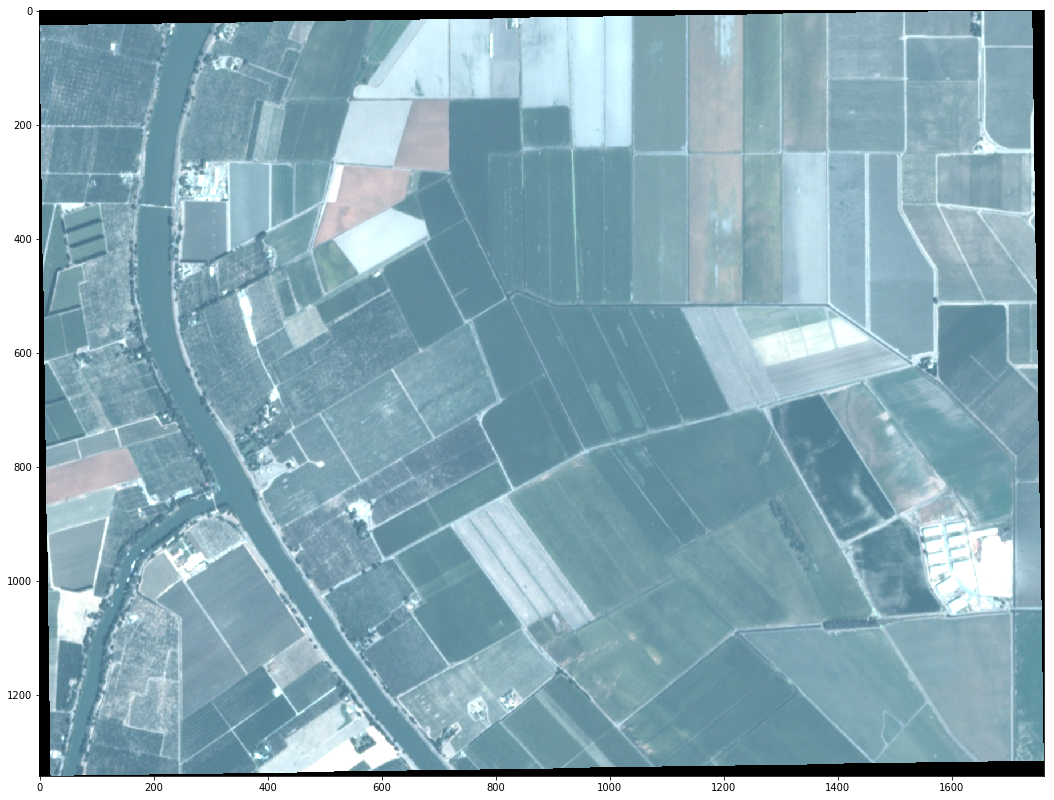

In [91]:
def to_display(masked_image):
    """Converts the masked image to a 3-band rgb, 8-bit array for display."""
    rgb_bands = create_masked_array(masked_image)[:,:,:3]
#     old_min = rgb_bands.min()
#     old_max = rgb_bands.max()
    old_min = np.percentile(rgb_bands, 2) # looks prettier than using the min val
    old_max = np.percentile(rgb_bands, 98) # looks prettier than using the max val
    return to_8_bit(rgb_bands, old_min, old_max)

plt.figure(1,figsize=(18,36))
plt.imshow(to_display(load_masked_image(cropped_file)))